## Assignment 3
This notebook builds neural network models that predict molecular properties from a database of simulations.

For more information here is a link to the competition: [kaggle.com/competitions/cap-4611-2021-fall-assignment-3/](kaggle.com/competitions/cap-4611-2021-fall-assignment-3/)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.random import set_seed 
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers

from numpy.random import seed

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from math import sqrt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# print(os.listdir("../input"))

# READ ME

**PLEASE NOTE** : These are global variables, we can increase them to get better results however it will make the runtime slower. I set them to be very low because Kaggle runs very slowly so the results are going to be horrible, to get good results please set the global variables to the recommended numbers



epoch_num -> the number of epochs we are going to train our 3 models on, **recommended to be 200**

num_models -> the number of times we are going to run each of our 3 models, **recommended to be 10**

num_max_trials -> When performing RandomSearch this is the number of "Searches" we are going to perform, **recommended to be 5**

num_executions_per_trial -> When perfoming RandomSearch this is the number of times we are going to perform each model that we find. **Recommended to be 3**

randomSearchEpoch -> When perfoming RandomSearch this is the number of epochs we peform for each model. **Recommended to be 15**

In [2]:
epoch_num = 60
num_models = 6
num_max_trials=5
num_executions_per_trial = 3
randomSearchEpoch = 10

# 1)You must load the data from the provided CSV files.

In [3]:
train = pd.read_csv("../input/datasetassignment3/train.csv/train.csv")
test = pd.read_csv("../input/datasetassignment3/eval.csv/eval.csv")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [5]:
X = train.iloc[:, :-1] 
y = train.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.22, shuffle = True)

X_eval = test.copy()


# 2) You must conduct exploratory data analysis, cleaning, and feature engineering on the data
You must describe and explain everything that you do to the data


**Exploring the target value 'Eat'**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


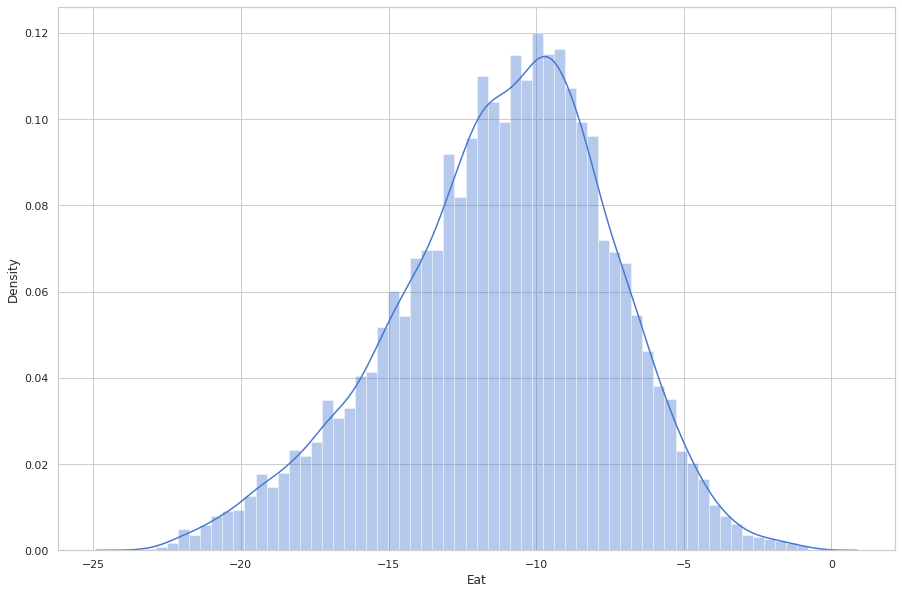

In [6]:
ax = sns.distplot(y, bins = 60, axlabel = 'Eat')


Looking at the distribution for our target varialbe "eat", it seems like we have a pretty basic distribution and don't need to do anything to it

In [7]:
#Here is a outlier detection function, which finds the indexes of outliers given a numerical variable.
def Zscore_outlier(df):
    retval = []
    mean = np.mean(df)
    std = np.std(df)
    index = 0
    
    for i in df: 
        z = (i - mean) / std
        if np.abs(z) > 4: 
            retval.append(index)

        index = index + 1
            
            
    return retval

        
Outliers = np.unique(Zscore_outlier(train['Eat']))
print("Outliers: ", Outliers)

Outliers:  []


We don't have any outliers outside 4 standard deviations, so I'm not going to remove any outliers.

**Exploring the Features**

In [8]:
train.isnull().sum().sort_values()

id     0
854    0
853    0
852    0
851    0
      ..
422    0
421    0
420    0
427    0
Eat    0
Length: 1278, dtype: int64

There are no missing features. So we don't have to do any feature engineering to fill those in

In [9]:
X.describe()

,id,0,1,2,3,4,5,6,7,8,...,1266,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id
count,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,...,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000,12993.000000
mean,6496.000000,116.244139,22.484154,20.507422,18.563918,17.199824,15.847108,15.150804,14.487618,13.974674,...,0.000151,0.000150,0.000148,0.004156,0.000147,0.000144,0.002347,0.000142,0.001347,33101.068883
std,3750.900359,113.729597,8.699268,7.711998,6.484718,5.505691,4.176694,3.868422,3.516000,3.367758,...,0.002907,0.002885,0.002859,0.045397,0.002830,0.002782,0.034180,0.002740,0.025917,23401.951232
min,0.000000,36.858105,2.906146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3248.000000,73.516695,17.993974,16.229604,15.176379,13.745581,13.653224,13.639635,12.762280,12.588049,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12309.000000
50%,6496.000000,73.516695,20.665957,18.632443,17.714561,16.021554,15.169079,13.877660,13.663518,13.652853,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27826.000000
75%,9744.000000,73.516695,21.139489,20.740126,18.714209,18.337209,17.667775,16.164715,15.497429,14.900133,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54864.000000
max,12992.000000,388.023441,66.779073,66.269180,66.268891,66.268756,66.268196,66.264158,66.258487,66.258177,...,0.062496,0.062225,0.061999,0.500000,0.061534,0.059760,0.500000,0.057834,0.500000,74977.000000


# 3) You must build and train at least three (3) Multilayer Perceptron models using TensorFlow (or tf.keras) on the training data and evaluate the performance of each model on a set of validation data

We are going to build a model to "generate" the best number of layers and number of neurons in each layer, we are going to run the three best generated models.

In [10]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32,
                                            ),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

We are going to implement early stopping to stop overfitting, however I recognize now that this was probably not the best approach.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta = 1e-3, patience = 18, verbose = 1, restore_best_weights = True)

# Model 1

In [12]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=num_max_trials,
    executions_per_trial=num_executions_per_trial,
    directory='project',
    project_name='a10')


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [13]:
tuner.search(X_train, y_train, epochs = randomSearchEpoch,  validation_data = (X_test, y_test))

Trial 5 Complete [00h 01m 09s]
val_mean_squared_error: 3.4482483863830566

Best val_mean_squared_error So Far: 0.6267352302869161
Total elapsed time: 00h 06m 32s


In [14]:
tuner.results_summary()

Results summary
Results in project/a10
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 11
units_0: 128
units_1: 224
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
Score: 0.6267352302869161
Trial summary
Hyperparameters:
num_layers: 12
units_0: 160
units_1: 416
learning_rate: 0.001
units_2: 128
units_3: 64
units_4: 320
units_5: 320
units_6: 256
units_7: 160
units_8: 480
units_9: 96
units_10: 160
units_11: 32
Score: 1.182387073834737
Trial summary
Hyperparameters:
num_layers: 8
units_0: 384
units_1: 224
learning_rate: 0.001
units_2: 384
units_3: 256
units_4: 352
units_5: 160
units_6: 224
units_7: 256
units_8: 128
units_9: 160
units_10: 32
Score: 2.2071890830993652
Trial summary
Hyperparameters:
num_layers: 11
units_0: 64
units_1: 448
learning_rate: 0.0001
units_2: 480
units_3: 288
units_4: 224
units_5: 512
units_6: 288
units_7: 32
u

Please note that rerunning the tuner will yield a different "best model". The model I use is going to be the best model I found when I rand the tuners.

In [15]:
# define base model
def refined_model1(optimizer = 'adam'):
 
    
       # create model
    model = Sequential()
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(224, activation='relu'))
    model.add(layers.Dense(448, activation='relu'))
    model.add(layers.Dense(448, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3),loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

Now we are going to run the model a number of times and generate the distribution to find out how good our model is.

**Please note num_models is set to 6, to increase the accuracy of the distribution you can increase this number**

In [16]:
model1VAL = []
model1 = []

for i in range(num_models):
  model1.append(KerasRegressor(build_fn=refined_model1, epochs = epoch_num))
  model1_result = model1[i].fit(X_train,y_train, validation_data = (X_test, y_test), callbacks = [monitor])
  

for i in range(num_models):
  model1VAL = sqrt(mean_squared_error(y_test, model1[i].predict(X_test)))
  print('Validation accuracy', model1VAL)


Epoch 1/60
317/317 [==============================] - 3s 7ms/step - loss: 24.2624 - root_mean_squared_error: 4.9257 - val_loss: 5.3937 - val_root_mean_squared_error: 2.3224
Epoch 2/60
317/317 [==============================] - 2s 6ms/step - loss: 6.8526 - root_mean_squared_error: 2.6178 - val_loss: 4.9006 - val_root_mean_squared_error: 2.2137
Epoch 3/60
317/317 [==============================] - 3s 8ms/step - loss: 4.9922 - root_mean_squared_error: 2.2343 - val_loss: 3.5639 - val_root_mean_squared_error: 1.8878
Epoch 4/60
317/317 [==============================] - 2s 6ms/step - loss: 4.1199 - root_mean_squared_error: 2.0298 - val_loss: 2.9190 - val_root_mean_squared_error: 1.7085
Epoch 5/60
317/317 [==============================] - 2s 6ms/step - loss: 3.4124 - root_mean_squared_error: 1.8473 - val_loss: 2.8441 - val_root_mean_squared_error: 1.6864
Epoch 6/60
317/317 [==============================] - 2s 6ms/step - loss: 3.1125 - root_mean_squared_error: 1.7642 - val_loss: 2.6221 - val

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


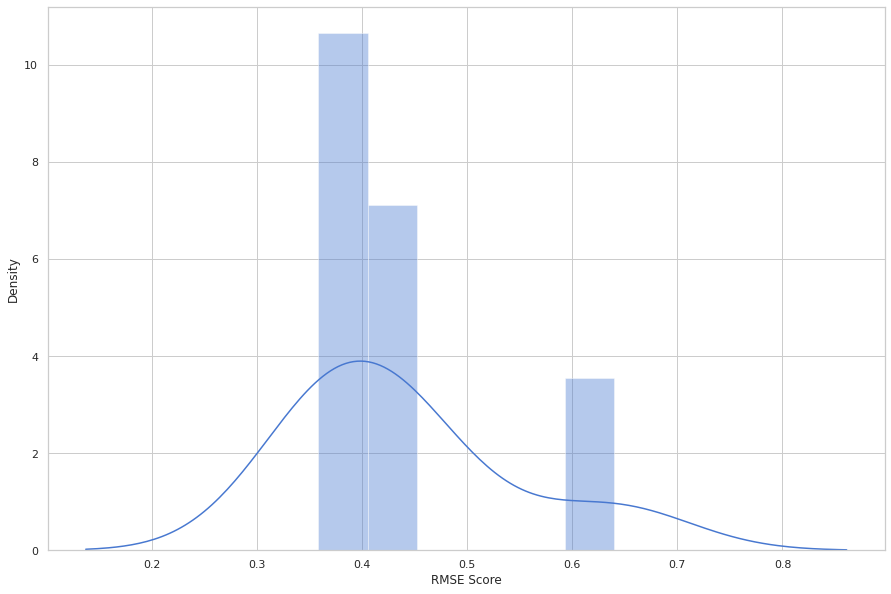

In [17]:
model1VAL = []
for i in range(num_models):
  model1VAL.append(sqrt(mean_squared_error(y_test, model1[i].predict(X_test))))

ax = sns.distplot(model1VAL, bins = num_models, axlabel = 'RMSE Score')

In [18]:
m1DF = pd.DataFrame(model1VAL, columns=['Score'])
print(m1DF)
m1DF.describe()

      Score
0  0.448004
1  0.366670
2  0.639658
3  0.379175
4  0.358182
5  0.450239


,Score
count,6.000000
mean,0.440321
std,0.105643
min,0.358182
25%,0.369797
50%,0.413590
75%,0.449680
max,0.639658


In [19]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=num_max_trials,
    executions_per_trial=num_executions_per_trial,
    directory='project',
    project_name='a20')

In [20]:
tuner.search(X_train, y_train, epochs = randomSearchEpoch,  validation_data = (X_test, y_test))

Trial 5 Complete [00h 02m 41s]
val_mean_squared_error: 0.5239487687746683

Best val_mean_squared_error So Far: 0.5239487687746683
Total elapsed time: 00h 08m 39s


In [21]:
tuner.results_summary()

Results summary
Results in project/a20
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 20
units_0: 384
units_1: 480
learning_rate: 0.001
units_2: 192
units_3: 96
units_4: 256
units_5: 384
units_6: 192
units_7: 128
units_8: 64
units_9: 192
units_10: 352
units_11: 224
units_12: 352
units_13: 320
units_14: 352
units_15: 352
units_16: 416
units_17: 160
units_18: 320
units_19: 448
Score: 0.5239487687746683
Trial summary
Hyperparameters:
num_layers: 14
units_0: 320
units_1: 384
learning_rate: 0.01
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
Score: 1.0655570030212402
Trial summary
Hyperparameters:
num_layers: 7
units_0: 384
units_1: 320
learning_rate: 0.0001
units_2: 256
units_3: 288
units_4: 96
units_5: 352
units_6: 320
units_7: 160
units_8: 192
units_9: 256
units_10: 64
units_11: 96
units_12: 256
units_13: 128
uni

In [22]:
# define base model
def refined_model2(optimizer = 'adam'):
 
    
       # create model
    model = Sequential()
    model.add(layers.Dense(320, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(480, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(288, activation='relu'))
    model.add(layers.Dense(160, activation='relu'))
    model.add(layers.Dense(224, activation='relu'))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(448, activation='relu'))
    model.add(layers.Dense(224, activation='relu'))
    model.add(layers.Dense(416, activation='relu'))
    model.add(layers.Dense(448, activation='relu'))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(224, activation='relu'))
    model.add(layers.Dense(448, activation='relu'))
    model.add(layers.Dense(416, activation='relu'))
    model.add(layers.Dense(288, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3),loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [23]:
model2VAL = []
model2 = []

for i in range(num_models):
  model2.append(KerasRegressor(build_fn=refined_model2, epochs = epoch_num))
  model2_result = model2[i].fit(X_train,y_train, validation_data = (X_test, y_test), callbacks = [monitor])
  

for i in range(num_models):
  model2VAL = sqrt(mean_squared_error(y_test, model2[i].predict(X_test)))
  print('Validation accuracy', model2VAL)

Epoch 1/60
317/317 [==============================] - 6s 15ms/step - loss: 21.7332 - root_mean_squared_error: 4.6619 - val_loss: 5.4415 - val_root_mean_squared_error: 2.3327
Epoch 2/60
317/317 [==============================] - 5s 15ms/step - loss: 6.7560 - root_mean_squared_error: 2.5992 - val_loss: 4.9396 - val_root_mean_squared_error: 2.2225
Epoch 3/60
317/317 [==============================] - 5s 16ms/step - loss: 4.9104 - root_mean_squared_error: 2.2159 - val_loss: 3.5668 - val_root_mean_squared_error: 1.8886
Epoch 4/60
317/317 [==============================] - 4s 14ms/step - loss: 2.8353 - root_mean_squared_error: 1.6838 - val_loss: 1.9280 - val_root_mean_squared_error: 1.3885
Epoch 5/60
317/317 [==============================] - 5s 15ms/step - loss: 2.9493 - root_mean_squared_error: 1.7174 - val_loss: 2.3891 - val_root_mean_squared_error: 1.5457
Epoch 6/60
317/317 [==============================] - 5s 14ms/step - loss: 1.8502 - root_mean_squared_error: 1.3602 - val_loss: 1.4267

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


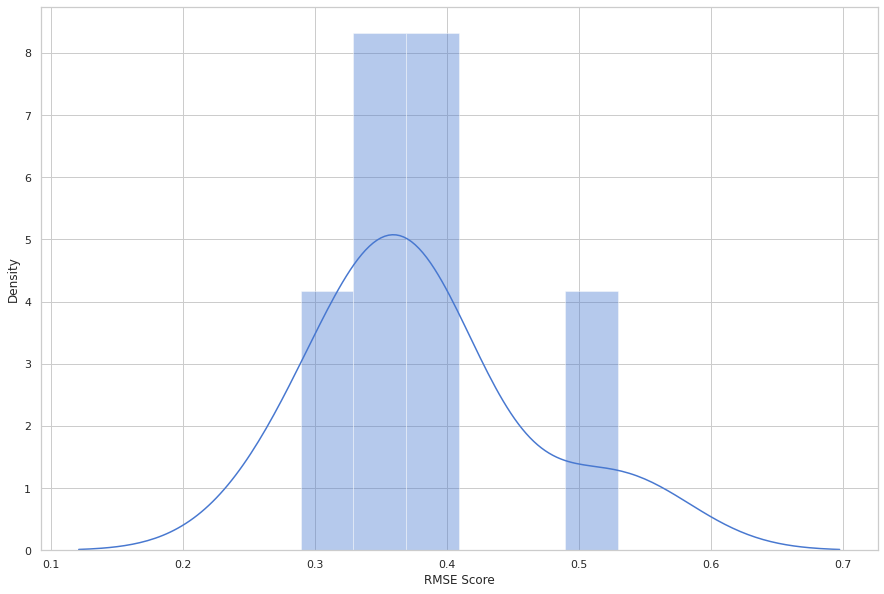

In [24]:
model2VAL = []
for i in range(num_models):
  model2VAL.append(sqrt(mean_squared_error(y_test, model2[i].predict(X_test))))

ax = sns.distplot(model2VAL, bins = num_models, axlabel = 'RMSE Score')

In [25]:
m2DF = pd.DataFrame(model2VAL, columns=['Score'])
print(m2DF)
m2DF.describe()

      Score
0  0.390148
1  0.289058
2  0.352876
3  0.353827
4  0.375352
5  0.529251


,Score
count,6.000000
mean,0.381752
std,0.080092
min,0.289058
25%,0.353114
50%,0.364589
75%,0.386449
max,0.529251


In [26]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=num_max_trials,
    executions_per_trial=num_executions_per_trial,
    directory='project',
    project_name='a30')

In [27]:
tuner.search(X_train, y_train, epochs = randomSearchEpoch ,  validation_data = (X_test, y_test))

Trial 5 Complete [00h 01m 56s]
val_mean_squared_error: 2.6303639014561973

Best val_mean_squared_error So Far: 1.2444443702697754
Total elapsed time: 00h 07m 36s


In [28]:
tuner.results_summary()

Results summary
Results in project/a30
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 10
units_0: 128
units_1: 256
learning_rate: 0.001
units_2: 256
units_3: 64
units_4: 384
units_5: 480
units_6: 256
units_7: 448
units_8: 352
units_9: 224
units_10: 160
units_11: 320
units_12: 96
Score: 1.2444443702697754
Trial summary
Hyperparameters:
num_layers: 13
units_0: 384
units_1: 384
learning_rate: 0.01
units_2: 256
units_3: 352
units_4: 416
units_5: 64
units_6: 64
units_7: 64
units_8: 160
units_9: 384
units_10: 32
units_11: 32
units_12: 32
Score: 1.5857305526733398
Trial summary
Hyperparameters:
num_layers: 17
units_0: 256
units_1: 480
learning_rate: 0.01
units_2: 256
units_3: 128
units_4: 352
units_5: 64
units_6: 128
units_7: 256
units_8: 480
units_9: 256
units_10: 352
units_11: 416
units_12: 192
units_13: 32
units_14: 32
units_15: 32
units_16: 32
Score: 2.6303639014561973
Trial summary
Hyperparameters:
num_layers: 1

In [29]:
# define base model
def refined_model3(optimizer = 'adam'):
 
    
       # create model
    model = Sequential()
    model.add(layers.Dense(192, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(352, activation='relu'))
    model.add(layers.Dense(320, activation='relu'))
    model.add(layers.Dense(224, activation='relu'))
    model.add(layers.Dense(288, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(288, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(320, activation='relu'))
    model.add(layers.Dense(384, activation='relu'))
    model.add(layers.Dense(384, activation='relu'))
    model.add(layers.Dense(384, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3),loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [30]:
model3VAL = []
model3 = []

for i in range(num_models):
  model3.append(KerasRegressor(build_fn=refined_model3, epochs = epoch_num))
  model3_result = model3[i].fit(X_train,y_train, validation_data = (X_test, y_test), callbacks = [monitor])
  

for i in range(num_models):
  model3VAL = sqrt(mean_squared_error(y_test, model3[i].predict(X_test)))
  print('Validation accuracy', model3VAL)

Epoch 1/60
317/317 [==============================] - 5s 13ms/step - loss: 30.5292 - root_mean_squared_error: 5.5253 - val_loss: 5.7162 - val_root_mean_squared_error: 2.3909
Epoch 2/60
317/317 [==============================] - 4s 13ms/step - loss: 5.6911 - root_mean_squared_error: 2.3856 - val_loss: 3.1205 - val_root_mean_squared_error: 1.7665
Epoch 3/60
317/317 [==============================] - 4s 12ms/step - loss: 3.2875 - root_mean_squared_error: 1.8131 - val_loss: 1.8734 - val_root_mean_squared_error: 1.3687
Epoch 4/60
317/317 [==============================] - 4s 13ms/step - loss: 2.2937 - root_mean_squared_error: 1.5145 - val_loss: 3.0143 - val_root_mean_squared_error: 1.7362
Epoch 5/60
317/317 [==============================] - 4s 12ms/step - loss: 2.0196 - root_mean_squared_error: 1.4211 - val_loss: 1.6090 - val_root_mean_squared_error: 1.2685
Epoch 6/60
317/317 [==============================] - 5s 14ms/step - loss: 1.3790 - root_mean_squared_error: 1.1743 - val_loss: 0.9179

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


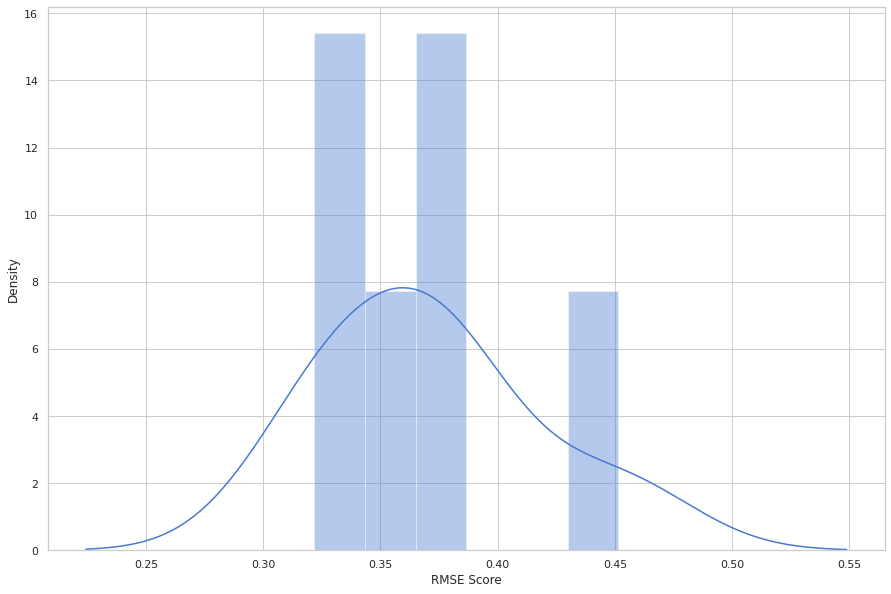

In [31]:
model3VAL = []
for i in range(num_models):
  model3VAL.append(sqrt(mean_squared_error(y_test, model3[i].predict(X_test))))


ax = sns.distplot(model3VAL, bins = num_models, axlabel = 'RMSE Score')

In [32]:
m3DF = pd.DataFrame(model3VAL, columns=['Score'])
print(m3DF)
m3DF.describe()

      Score
0  0.378826
1  0.381375
2  0.321781
3  0.330107
4  0.451449
5  0.363073


,Score
count,6.000000
mean,0.371102
std,0.046472
min,0.321781
25%,0.338348
50%,0.370949
75%,0.380738
max,0.451449


# 4) You must select the best model that you have generated and use that model to predict the target vector for the test data

**AGAIN PLEASE NOTE THESE ARE GOING TO BE HORRIBLE RMSE, PLEASE SET GLOBAL VARIABLES TO RECOMMENDED VALUES TO GET GOOD SCORES**

We are going through every model we made, and submit the one with the best RMSE score.

In [33]:
finalModels = model1 + model2 + model3
finalModelsVal = model1VAL + model2VAL + model3VAL

max_Val = min(finalModelsVal)
max_ValIndex = finalModelsVal.index(max_Val)


Y_pred = finalModels[max_ValIndex].predict(X_eval)


submit = pd.DataFrame({'id': test['id'], 'Eat': Y_pred})

submit.to_csv('submission.csv', index = False)
print("Submission GOOD")
print(finalModelsVal[max_ValIndex])

Submission GOOD
0.2890578262280234


In [34]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(submit)

        id        Eat
0        0 -10.409284
1        1 -12.843822
2        2 -16.717638
3        3 -12.662108
4        4  -8.945182
5        5 -19.996700
6        6  -5.021519
7        7 -11.870907
8        8  -9.125360
9        9 -16.956541
10      10 -19.082102
11      11 -20.376152
12      12 -10.069177
13      13 -11.418498
14      14 -10.552001
15      15  -9.042546
16      16 -12.594032
17      17  -4.952273
18      18  -9.638292
19      19  -6.073633
20      20 -14.153957
21      21  -5.437200
22      22  -2.424619
23      23  -5.376959
24      24  -7.782465
25      25 -10.761104
26      26 -18.305096
27      27 -14.053969
28      28 -14.886054
29      29 -15.227554
30      30  -8.070847
31      31  -3.005905
32      32 -11.518689
33      33 -11.642848
34      34 -16.023102
35      35  -7.624707
36      36  -9.287052
37      37 -14.225640
38      38  -9.798098
39      39 -13.409081
40      40 -14.806473
41      41 -12.802890
42      42  -8.136273
43      43  -9.559813
44      44